<a href="https://colab.research.google.com/github/mathewsjob/Master-Thesis/blob/main/LSTMV2_Relu_Lr%3D0_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the necessary packages**

In [1]:
import cv2
from keras.models import load_model
import glob
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import skimage.io
from PIL import Image, ImageEnhance

import imageio

import random
from collections import Counter
# from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
#from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, Lambda, Dense, Flatten, LSTM
from keras.models import Model


from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path = 'drive/My Drive/DataAug'

In [4]:
path

'drive/My Drive/DataAug'

In [5]:
os.listdir(path)

['normal-pylorus',
 'normal-cecum',
 'dyed-lifted-polyps',
 'polyps',
 'normal-z-line',
 'esophagitis',
 'dyed-resection-margins',
 'ulcerative-colitis']

In [6]:
#directory = 'drive/My Drive/PreProcessed/'

directory = 'drive/My Drive/DataAug'
# train_dir = os.path.join(directory, 'train_dir')
# validation_dir = os.path.join(directory, 'validation_dir')
#directory = 'drive/My Drive/kvasir/kvasir-dataset'

categories = ['ulcerative-colitis','dyed-lifted-polyps','esophagitis','normal-pylorus','normal-z-line','polyps','dyed-resection-margins','normal-cecum']

1.2. Define dataset categories
Here we define the categories (classes) of the dataset from the names of the folders of the dataset. The dataset consists of 8 folders (one for each class) named according to their category, each folder contains 1000 images.

In [7]:
def get_dataCategories(directory):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(directory, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])




categories, nbr_files = get_dataCategories(directory)

# Create DataFrame
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,categories,number of files
0,dyed-lifted-polyps,4999
1,dyed-resection-margins,5000
2,esophagitis,4999
3,normal-cecum,4999
4,normal-pylorus,4985
5,normal-z-line,5000
6,polyps,4995
7,ulcerative-colitis,4999



1.3. Create the set of features X as well as the labels y
to do this we read each image of the dataset and we put it in X, and we save the class of the image read in y.

Note: the read images are resized to 100x100 to speed up the learning step

In [8]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        reads the images from the dataset and resizes them using the dimensions
        (img_wid x img_high ) to create all X features and y labels

    args:
        datadir (str): dataset path
        categories (str): the different classes of the dataset
        img_wid(int): custom width
        img_high(int): custom height

    Returns:
        X(numpy): the set of features (i.e: includes all the images read)
        y(numpy): the set of labels (i.e: includes the categories of each image of X)
    """
    
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))
                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y




img_wid, img_high = 100, 100
X, y = create_dataset(directory, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (39976, 100, 100, 3)
y: (39976,)


1.4. Display a random image for each category
We display for each class a random image

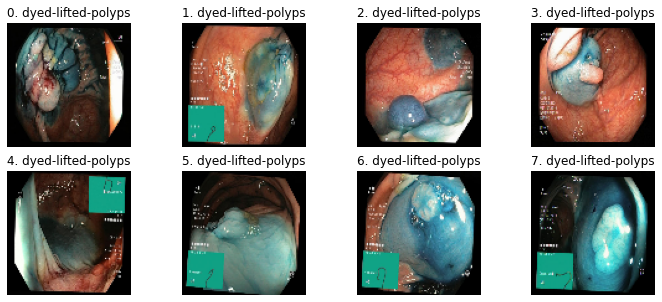

In [9]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

2. Creation of the model and learning
2.1. Create the training, testing and validation set
In this step we create:

the x_train/y_taine training set
the test set x_test/y_test
the validation set x_val/y_va
2.1.1. The set of training (X/y)train and test (X/y)test
We divide the data (X, y) into training and testing sets using 80% of the data for training and the remaining 20% ​​for testing.

In [10]:
# to convert y to scaler format
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42, stratify=Y
)
print(f"X_train: {X_train.shape}")
print(f"Y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")



X_train: (31980, 100, 100, 3)
Y_train: (31980, 1)
X_test: (7996, 100, 100, 3)
y_test: (7996, 1)


2.1.2. Create the validation set x_val/y_val
Here we divide 30% of the training set into a validation set

In [11]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{X_test.shape},  y_test:{y_test.shape}")


x_train:(22386, 100, 100, 3),  y_train:(22386, 1)
x_val:(9594, 100, 100, 3),  y_val:(9594, 1)
x_test:(7996, 100, 100, 3),  y_test:(7996, 1)


2.1.3. OneHot Encoding
We have to do a OneHot Encoding with to_categorical, to transform all the lables (y_train, y_val and y_test) so that we have a vector for each example, because we have 8 classes and we should expect what the shape of (y_train, y_val and y_test) goes from 1 to 8

In [12]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{X_test.shape},  y_test:{y_test.shape}")

x_train:(22386, 100, 100, 3),  y_train:(22386, 8)
x_val:(9594, 100, 100, 3),  y_val:(9594, 8)
x_test:(7996, 100, 100, 3),  y_test:(7996, 8)


2.2. Generating images
Here we will perform the image data augmentation. This is the technique used to increase the size of a training dataset by creating modified versions of images in the dataset. The creation of these modified images is done by randomly rotating these images by any degree between 0 and 360.

First, we'll define individual ImageDataGenerator instances for augmentation, and then scale them to each of the training, testing, and validation datasets.

In [13]:
# Image Data Augmentation
train_generator = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.3,0.9])

val_generator = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.3,0.9])

test_generator = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.3,0.9])

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(X_test)

In [14]:
print(x_train.shape)
print(x_val.shape)
print(X_test.shape)

(22386, 100, 100, 3)
(9594, 100, 100, 3)
(7996, 100, 100, 3)


2.3. Download the VGG19 pre-trained model
Now we will instantiate the VGG19 model which is a pre-trained convolutional neural network as a transfer learning model.

The biggest advantage of this network is that it has been pre-trained on over a million images from the ImageNet database.

A pre-trained network can classify images into thousands of object categories. Because of this advantage, we will apply this model to our dataset which has 8 categories, adding other layers to it.

In [15]:

base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )


219055592/219055592 [==============================] - 1s 0us/step


We will now define VGG19 as a deep learning architecture. For this, it will be defined as a sequential model of Keras with several dense layers.

In [22]:
model = Sequential()
model.add(base_model)

model.add(Flatten())

In [23]:
model.add(Dense(1024, activation=("ReLU"), input_dim=512))
model.add(Dense(512, activation=("ReLU")))
model.add(Dense(256, activation=("ReLU")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("ReLU")))
model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

In [24]:
# model.add(LSTM(128, input_shape=(100,3),activation ='relu',return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(128,activation ='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(32, activation=("ReLU")))
# model.add(Dropout(0.3))

# model.add(Dense(y_train.shape[1], activation=("softmax")))



Now to add more layers we need to see the dimension of our model.

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1573888   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

Add dense layers with batch activation and normalization

2.4. Hyperparametering

Hyperparameters are tunable parameters that allow us to control the model training process. Model performance is highly dependent on hyperparameters.

As we have defined our model, now we need to initialize the necessary hyperparameters to train the model, and then finally, we will compile our model.

In [26]:
""" Initializing the hyperparameters """

# initialize the number of training samples
batch_size = 100

# initialize the number of iterations
epochs = 20

# learning rate
learn_rate = 0.001

# initialize gradient descent
#op = tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
op= tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")

#adam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

# initialization of the Adam gradient descent
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# METRICS = [
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall'),
#         tf.keras.metrics.AUC(name='AUC')
        
#     ]

# compile the model
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=opt,metrics='accuracy')
#model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=METRICS)
model.compile(optimizer=op, loss="categorical_crossentropy", metrics='accuracy')

Learning rate reduction decreases the learning rate after a certain number of iterations if the error rate does not change. Here, thanks to this technique, we will monitor the accuracy of the validation and if it stops improving we will reduce the learning rate by 0.01.

In [27]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.01, patience=3, min_lr=1e-5)

2.5. Model training
Now we start training our model.

In [28]:

history = model.fit(
        #train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train, y_train,
        epochs=epochs,
        steps_per_epoch = len(x_train)//batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps = len(X_test)//batch_size ,callbacks=[lrr],
        verbose=1
    )
history = history. history


Epoch 1/20
223/223 [==============================] - 103s 338ms/step - loss: 0.5254 - accuracy: 0.8106 - val_loss: 0.8461 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 2/20
223/223 [==============================] - 71s 319ms/step - loss: 0.2553 - accuracy: 0.9105 - val_loss: 0.6833 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 3/20
223/223 [==============================] - 71s 318ms/step - loss: 0.2115 - accuracy: 0.9274 - val_loss: 0.5574 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 4/20
223/223 [==============================] - 71s 318ms/step - loss: 0.1562 - accuracy: 0.9487 - val_loss: 0.7311 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 5/20
223/223 [==============================] - 71s 318ms/step - loss: 0.1360 - accuracy: 0.9543 - val_loss: 0.5122 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 6/20
223/223 [==============================] - 71s 318ms/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 0.6604 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 7/20
223/223 [==============================]

223/223 [==============================] - 65s 293ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.4619 - val_accuracy: 0.8884 - lr: 1.0000e-05


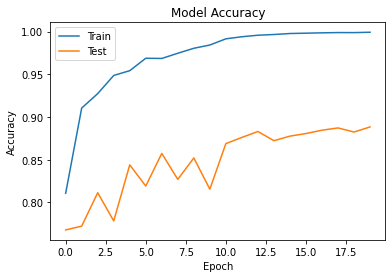

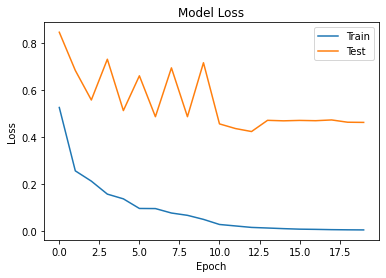

In [29]:
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

3. Model evaluation
3.1. Evaluate accuracy on the test set
Evaluate the accuracy as well as the loss of the model on the test set

In [30]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))


Test loss: 0.173
Test accuracy: 0.961


3.2. Confusion Matrix
Finally, we will visualize classification performance on test data using confusion matrices.

In [31]:
"""
   The functions uses displays the confusion matrix
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
       display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

Predict test set classes

In [32]:
# Making prediction
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

250/250 [==============================] - 13s 39ms/step


Displays the normalized and unnormalized confusion matrix.

We will see the exact number of correct and incorrect classifications using the unnormalized confusion matrix, and then we will see the same in percentage using the normalized confusion matrix.

As can be seen by classifying the images into 8 classes, the model gave a minimum accuracy of 79% and a maximum accuracy of 97%. We can further refine the training parameters and retrain our model to see any possible scaling in the classification

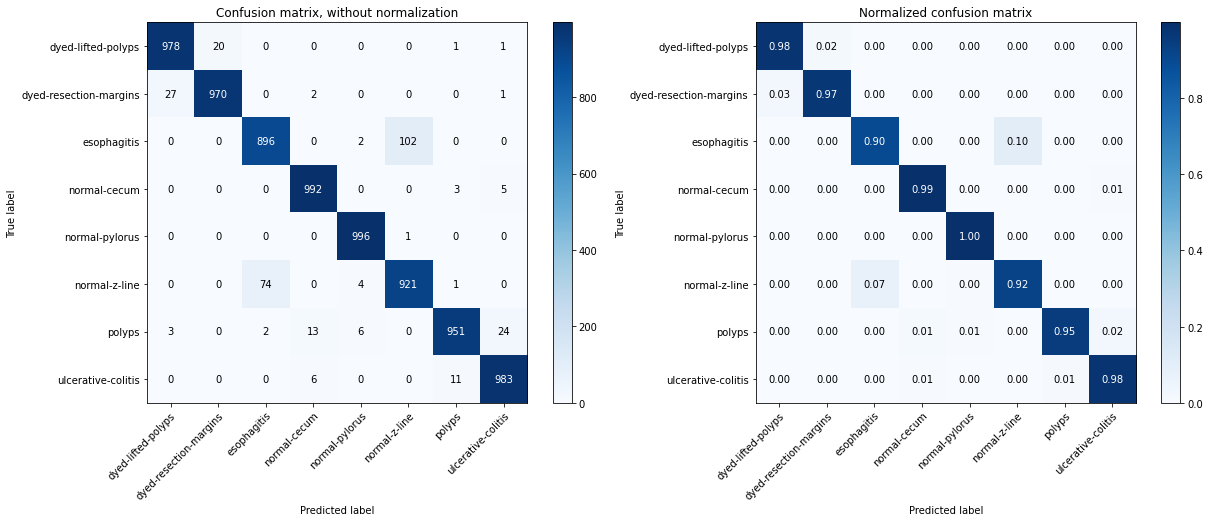

In [33]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

3.3. Random prediction
Predict randomly chosen images and compare the prediction with the ground truth

1/1 [==============================] - 0s 41ms/step


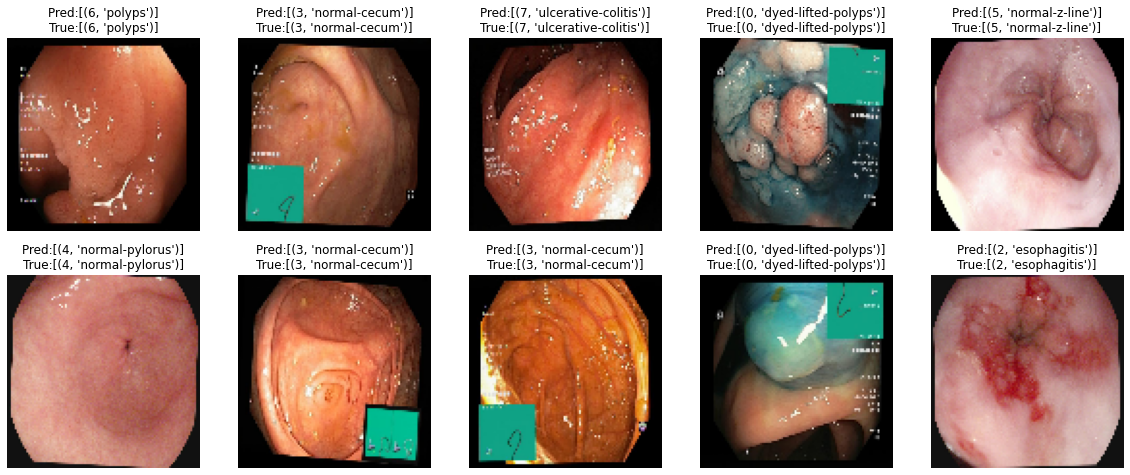

In [34]:
def predict_categorie_img(img, model, categories):
    """
        predire la classe d'une image donnee

    Args:
        img (numpay): l'image donnee
        model (_type_): le model utilise pour la prediction
        categories (list): liste des classes

    Raises:
        TypeError: erreur si l'image n'est pas en RGB (image_dim < 3)

    Returns:
        int: l'index de la classes predie
        str: la classe predie
    """    
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]





plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()